# Data 

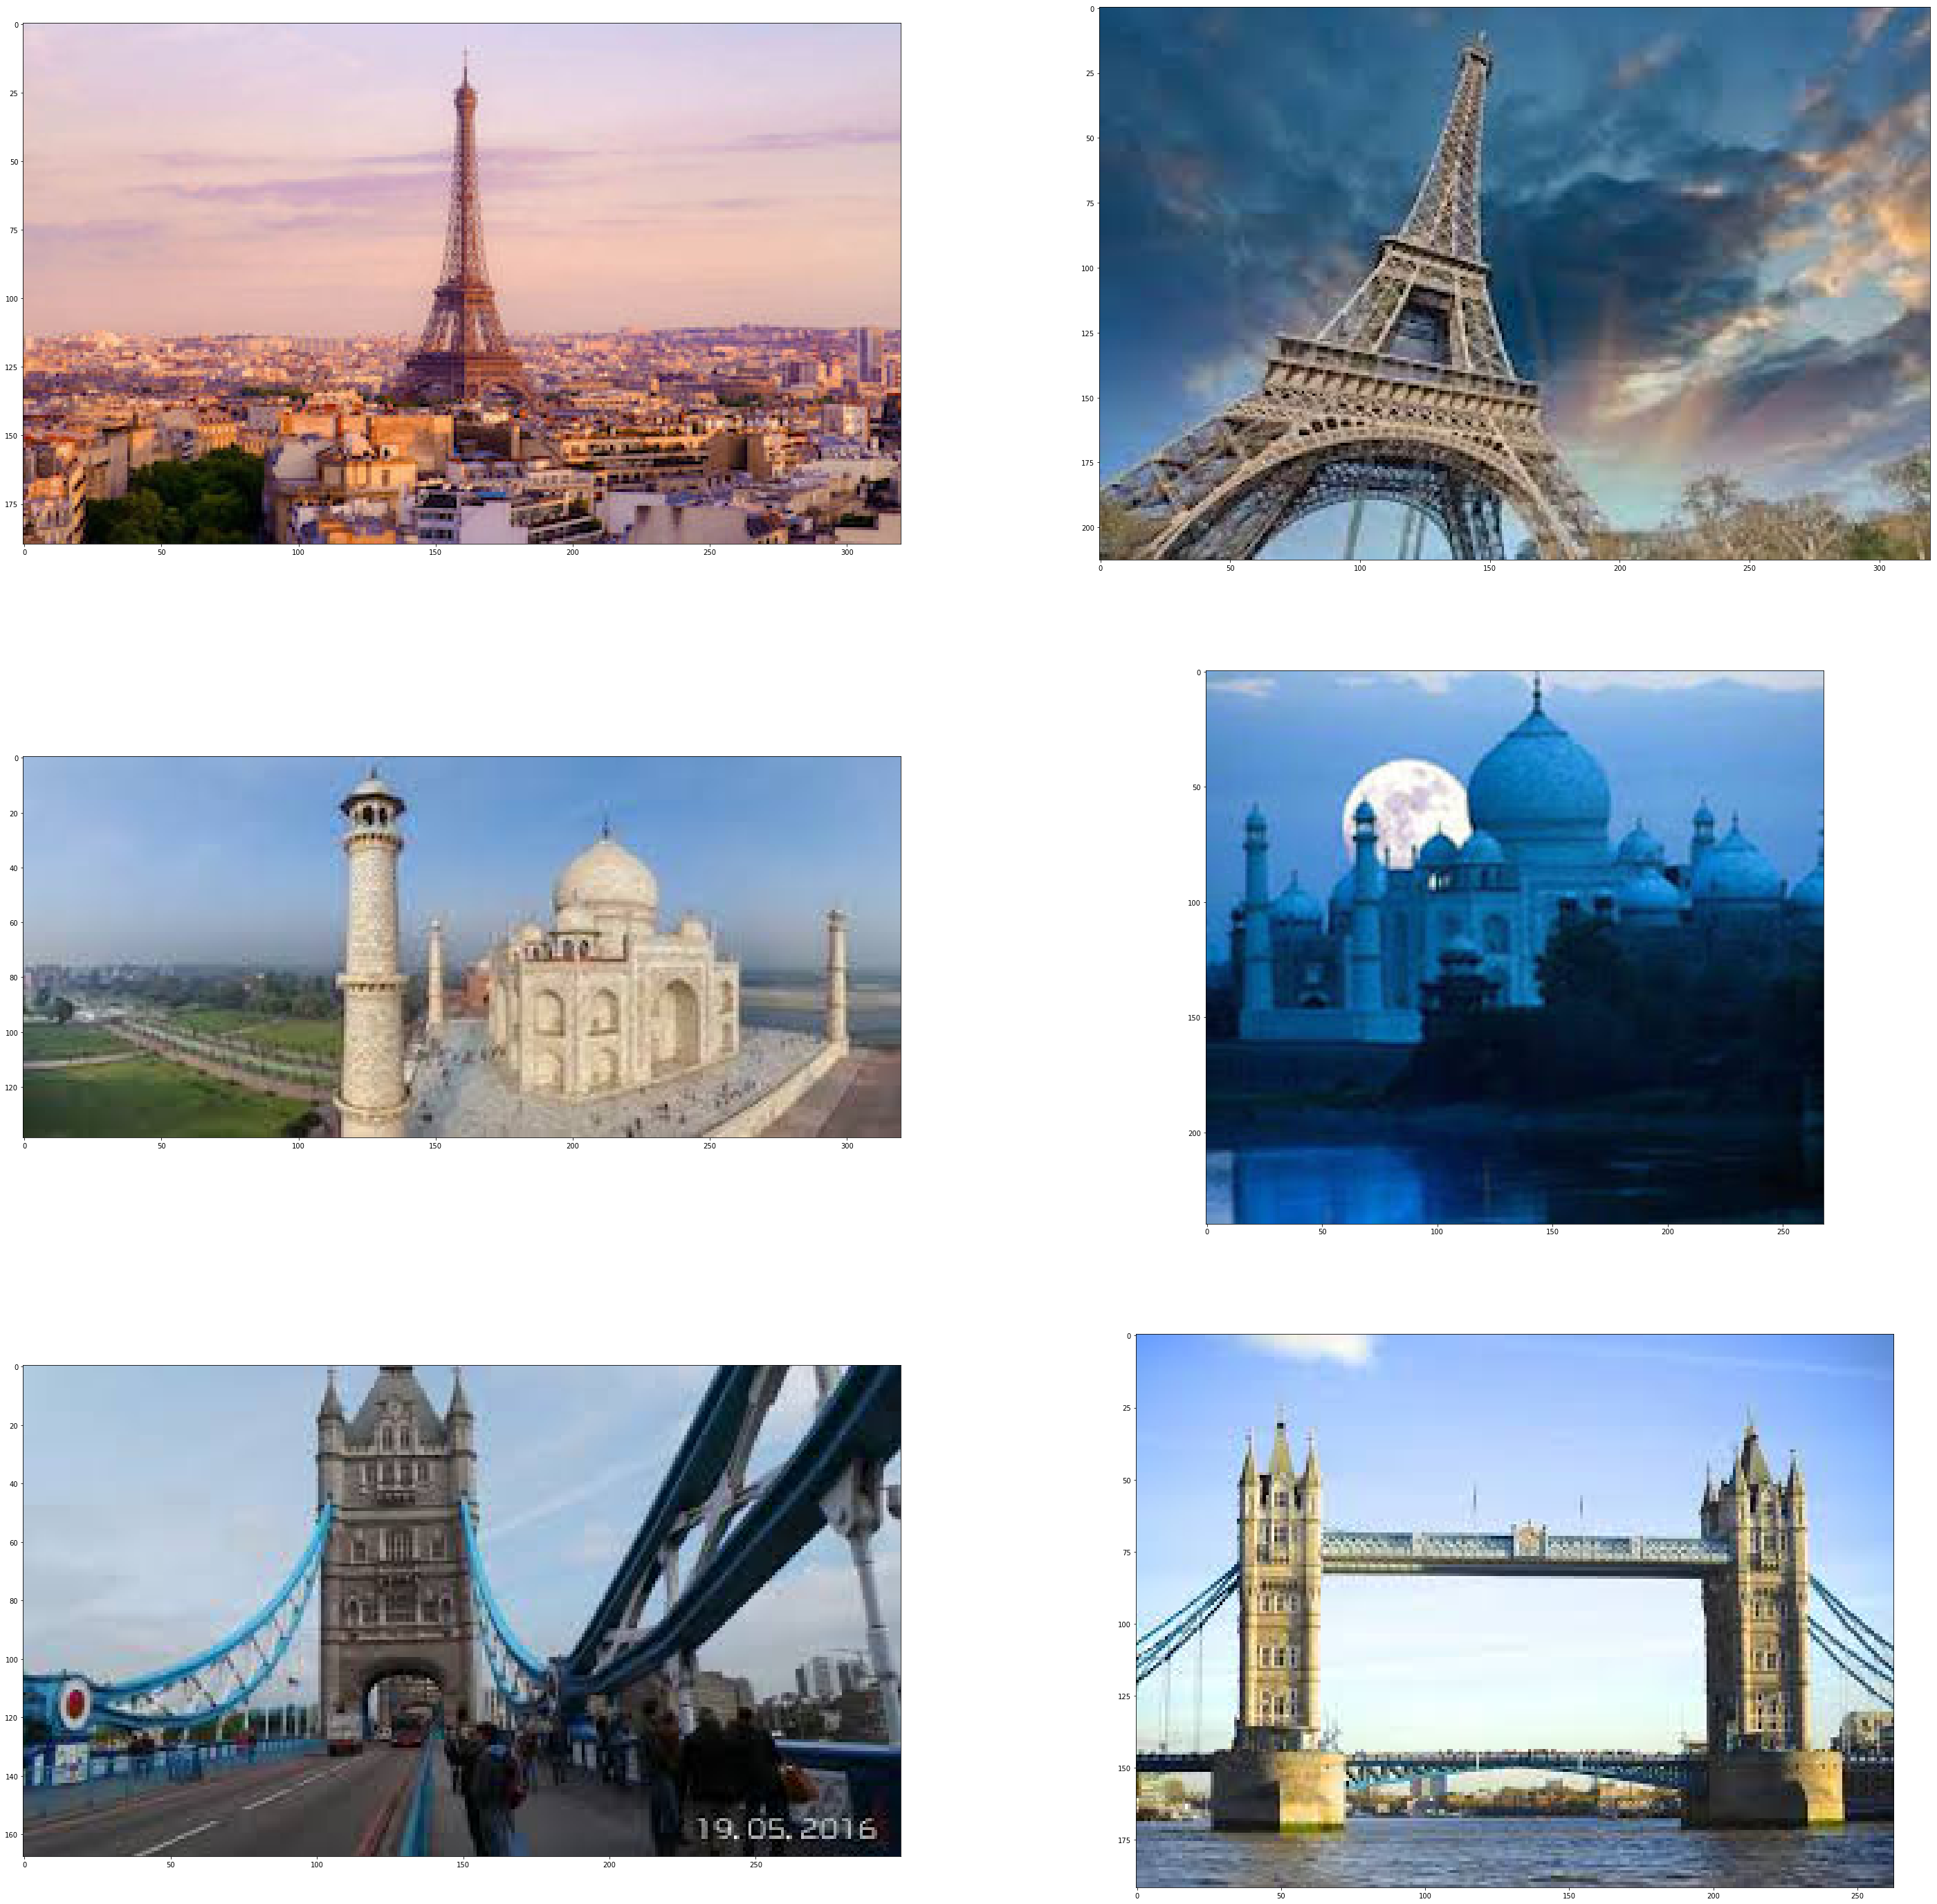

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import requests
from io import BytesIO
%matplotlib inline

EXAMPLE_NUM = 1
SAMPLE_NUM = 3

w=10
h=10
lst =['e.jpg', 'e1.jpg', 't.jpg', 't1.jpg', 'l.jpg', 'l2.jpg' ]
fig=plt.figure(figsize=(50, 50))
columns = EXAMPLE_NUM+1
rows = SAMPLE_NUM
for i in range(1, columns*rows +1):
    img = Image.open(lst[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Extracting Features

In [8]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os
import sys
import time

import tensorflow as tf

from google.protobuf import text_format
from tensorflow.python.platform import app
from delf import delf_config_pb2
from delf import feature_extractor
from delf import feature_io

cmd_args = None

# Extension of feature files.
_DELF_EXT = '.delf'

# Pace to report extraction log.
_STATUS_CHECK_ITERATIONS = 100

In [9]:
def _ReadImageList(list_path):
  """Helper function to read image paths.

  Args:
    list_path: Path to list of images, one image path per line.

  Returns:
    image_paths: List of image paths.
  """
  with tf.gfile.GFile(list_path, 'r') as f:
    image_paths = f.readlines()
  image_paths = [entry.rstrip() for entry in image_paths]
  return image_paths


def main():
  tf.logging.set_verbosity(tf.logging.INFO)

  # Read list of images.
  tf.logging.info('Reading list of images...')
  image_paths = _ReadImageList(cmd_args.list_images_path)
  num_images = len(image_paths)
  tf.logging.info('done! Found %d images', num_images)

  # Parse DelfConfig proto.
  config = delf_config_pb2.DelfConfig()
  with tf.gfile.FastGFile(cmd_args.config_path, 'r') as f:
    text_format.Merge(f.read(), config)

  # Create output directory if necessary.
  if not os.path.exists(cmd_args.output_dir):
    os.makedirs(cmd_args.output_dir)

  # Tell TensorFlow that the model will be built into the default Graph.
  with tf.Graph().as_default():
    # Reading list of images.
    filename_queue = tf.train.string_input_producer(image_paths, shuffle=False)
    reader = tf.WholeFileReader()
    _, value = reader.read(filename_queue)
    image_tf = tf.image.decode_jpeg(value, channels=3)

    with tf.Session() as sess:
      # Initialize variables.
      init_op = tf.global_variables_initializer()
      sess.run(init_op)

      # Loading model that will be used.
      tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING],
                                 config.model_path)
      graph = tf.get_default_graph()
      input_image = graph.get_tensor_by_name('input_image:0')
      input_score_threshold = graph.get_tensor_by_name('input_abs_thres:0')
      input_image_scales = graph.get_tensor_by_name('input_scales:0')
      input_max_feature_num = graph.get_tensor_by_name(
          'input_max_feature_num:0')
      boxes = graph.get_tensor_by_name('boxes:0')
      raw_descriptors = graph.get_tensor_by_name('features:0')
      feature_scales = graph.get_tensor_by_name('scales:0')
      attention_with_extra_dim = graph.get_tensor_by_name('scores:0')
      attention = tf.reshape(attention_with_extra_dim,
                             [tf.shape(attention_with_extra_dim)[0]])

      locations, descriptors = feature_extractor.DelfFeaturePostProcessing(
          boxes, raw_descriptors, config)

      # Start input enqueue threads.
      coord = tf.train.Coordinator()
      threads = tf.train.start_queue_runners(sess=sess, coord=coord)
      start = time.clock()
      for i in range(num_images):
        # Write to log-info once in a while.
        if i == 0:
          tf.logging.info('Starting to extract DELF features from images...')
        elif i % _STATUS_CHECK_ITERATIONS == 0:
          elapsed = (time.clock() - start)
          tf.logging.info('Processing image %d out of %d, last %d '
                          'images took %f seconds', i, num_images,
                          _STATUS_CHECK_ITERATIONS, elapsed)
          start = time.clock()

        # # Get next image.
        im = sess.run(image_tf)

        # If descriptor already exists, skip its computation.
        out_desc_filename = os.path.splitext(os.path.basename(
            image_paths[i]))[0] + _DELF_EXT
        out_desc_fullpath = os.path.join(cmd_args.output_dir, out_desc_filename)
        if tf.gfile.Exists(out_desc_fullpath):
          tf.logging.info('Skipping %s', image_paths[i])
          continue

        # Extract and save features.
        (locations_out, descriptors_out, feature_scales_out,
         attention_out) = sess.run(
             [locations, descriptors, feature_scales, attention],
             feed_dict={
                 input_image:
                     im,
                 input_score_threshold:
                     config.delf_local_config.score_threshold,
                 input_image_scales:
                     list(config.image_scales),
                 input_max_feature_num:
                     config.delf_local_config.max_feature_num
             })

        feature_io.WriteToFile(out_desc_fullpath, locations_out,
                               feature_scales_out, descriptors_out,
                               attention_out)

      # Finalize enqueue threads.
      coord.request_stop()
      coord.join(threads)


if __name__ == '__main__':
  parser = argparse.ArgumentParser()
  parser.register('type', 'bool', lambda v: v.lower() == 'true')
  parser.add_argument(
      '--config_path',
      type=str,
      default='delf_config_example.pbtxt',
      help="""
      Path to DelfConfig proto text file with configuration to be used for DELF
      extraction.
      """)
  parser.add_argument(
      '--list_images_path',
      type=str,
      default='train_list.txt',
      help="""
      Path to list of images whose DELF features will be extracted.
      """)
  parser.add_argument(
      '--output_dir',
      type=str,
      default='test_features',
      help="""
      Directory where DELF features will be written to. Each image's features
      will be written to a file with same name, and extension replaced by .delf.
      """)
  cmd_args, unparsed = parser.parse_known_args()
  main()


INFO:tensorflow:Reading list of images...
INFO:tensorflow:done! Found 8 images
INFO:tensorflow:Restoring parameters from b'parameters/delf_v1_20171026/model/variables/variables'
INFO:tensorflow:Starting to extract DELF features from images...
INFO:tensorflow:Skipping t1.jpg
INFO:tensorflow:Skipping t.jpg
INFO:tensorflow:Skipping e1.jpg
INFO:tensorflow:Skipping e.jpg
INFO:tensorflow:Skipping n.jpg
INFO:tensorflow:Skipping n2.jpg
INFO:tensorflow:Skipping l.jpg
INFO:tensorflow:Skipping l2.jpg


# Matching Images

In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
import tensorflow as tf

from tensorflow.python.platform import app
from delf import feature_io

cmd_args = None

_DISTANCE_THRESHOLD = 0.8

INFO:tensorflow:data/train_features/t1.delf...data/query_features/t.delf
t1.jpg t.jpg
INFO:tensorflow:data/train_features/e1.delf...data/query_features/t.delf
e1.jpg t.jpg
INFO:tensorflow:data/train_features/n2.delf...data/query_features/t.delf
INFO:tensorflow:data/train_features/l2.delf...data/query_features/t.delf
l2.jpg t.jpg
INFO:tensorflow:data/train_features/t1.delf...data/query_features/e.delf
t1.jpg e.jpg
INFO:tensorflow:data/train_features/e1.delf...data/query_features/e.delf
e1.jpg e.jpg
INFO:tensorflow:data/train_features/n2.delf...data/query_features/e.delf
INFO:tensorflow:data/train_features/l2.delf...data/query_features/e.delf
l2.jpg e.jpg
INFO:tensorflow:data/train_features/t1.delf...data/query_features/n.delf
t1.jpg n.jpg
INFO:tensorflow:data/train_features/e1.delf...data/query_features/n.delf


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_geometric.py:684: RuntimeWarning: divide by zero encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_geometric.py:684: RuntimeWarning: invalid value encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/measure/fit.py:931: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


e1.jpg n.jpg
INFO:tensorflow:data/train_features/n2.delf...data/query_features/n.delf
n2.jpg n.jpg
INFO:tensorflow:data/train_features/l2.delf...data/query_features/n.delf
l2.jpg n.jpg
INFO:tensorflow:data/train_features/t1.delf...data/query_features/l.delf
t1.jpg l.jpg
INFO:tensorflow:data/train_features/e1.delf...data/query_features/l.delf
e1.jpg l.jpg
INFO:tensorflow:data/train_features/n2.delf...data/query_features/l.delf
n2.jpg l.jpg
INFO:tensorflow:data/train_features/l2.delf...data/query_features/l.delf
l2.jpg l.jpg


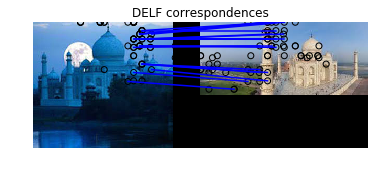

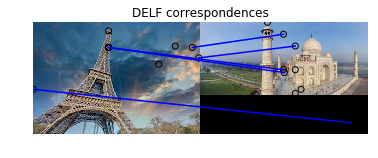

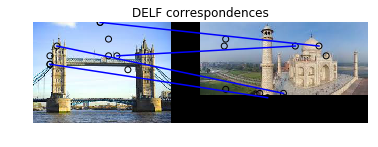

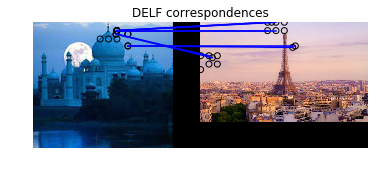

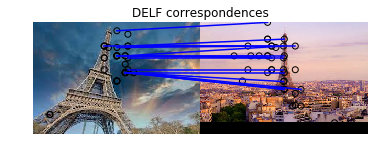

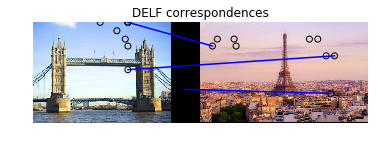

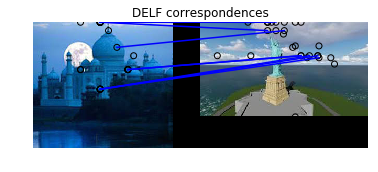

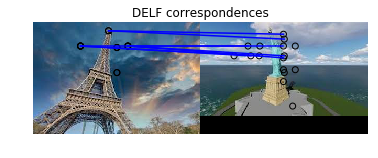

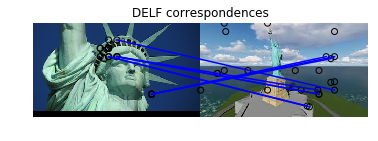

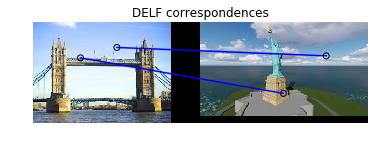

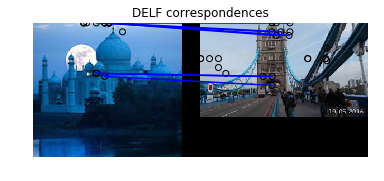

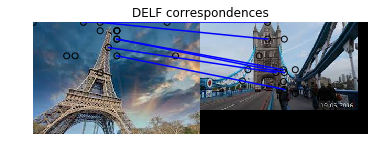

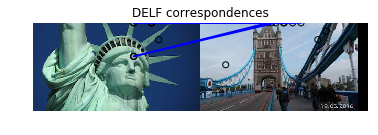

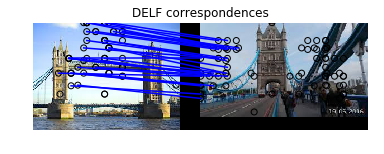

In [12]:
def _ReadImageList(list_path):
  """Helper function to read image paths.

  Args:
    list_path: Path to list of images, one image path per line.

  Returns:
    image_paths: List of image paths.
  """
  with tf.gfile.GFile(list_path, 'r') as f:
    image_paths = f.readlines()
  image_paths = [entry.rstrip() for entry in image_paths]
  return image_paths

def main():

  tf.logging.set_verbosity(tf.logging.INFO)
  


  query_image_paths =_ReadImageList(cmd_args.query_list_images_path)
  train_image_paths = _ReadImageList(cmd_args.train_list_images_path)

  output_fh = open(cmd_args.output_file, 'w')


  for query in query_image_paths:
    # Read features.
    locations_1, _, descriptors_1, _, _ = feature_io.ReadFromFile(
        query)
    num_features_1 = locations_1.shape[0]
    #tf.logging.info("Loaded image 1's %d features" % num_features_1)

    best_f = ""
    best_inliers = 0
    for train in train_image_paths:
      tf.logging.info(train+"..."+ query)

      locations_2, _, descriptors_2, _, _ = feature_io.ReadFromFile(
          train)
      num_features_2 = locations_2.shape[0]
      #tf.logging.info("Loaded image 2's %d features" % num_features_2)

      # Find nearest-neighbor matches using a KD tree.
      d1_tree = cKDTree(descriptors_1)
      _, indices = d1_tree.query(
          descriptors_2, distance_upper_bound=_DISTANCE_THRESHOLD)

      # Select feature locations for putative matches.
      locations_2_to_use = np.array([
          locations_2[i,]
          for i in range(num_features_2)
          if indices[i] != num_features_1
      ])
      locations_1_to_use = np.array([
          locations_1[indices[i],]
          for i in range(num_features_2)
          if indices[i] != num_features_1
      ])

      # Perform geometric verification using RANSAC.
      try:
        _, inliers = ransac(
            (locations_1_to_use, locations_2_to_use),
            AffineTransform,
            min_samples=3,
            residual_threshold=20,
            max_trials=100)

        if(len(inliers) > best_inliers):
            best_inliers = len(inliers)
            best_label = train

            #print(best_label, train, query)
      except:
        continue
        
        #Visualize correspondences, and save to file.
      _, ax = plt.subplots()
      tr_im = train.split('data/train_features/')[1].split('.delf')[0]+'.jpg'
      tt_im = query.split('data/query_features/')[1].split('.delf')[0]+'.jpg'
      output_im = tt_im[0]+"->"+tr_im[:2]+".jpg"
      print(tr_im, tt_im)
      img_1 = mpimg.imread(tr_im)
      img_2 = mpimg.imread(tt_im)
      inlier_idxs = np.nonzero(inliers)[0]
      plot_matches(
          ax,
          img_1,
          img_2,
          locations_1_to_use,
          locations_2_to_use,
          np.column_stack((inlier_idxs, inlier_idxs)),
          matches_color='b')
      ax.axis('off')
      ax.set_title('DELF correspondences')
      plt.savefig(output_im)
       
        
        

        

      #print(best_label, train, query)

      #tf.logging.info('Found %d inliers' % sum(inliers))
    if(best_inliers>20):
        output_fh.write(query.split('data/query_features/')[1]\
          + ","+best_label.split('data/train_features/')[1]+"\n")
    else:
        output_fh.write(query+"\n")

  output_fh.close()


      # Visualize correspondences, and save to file.
      # _, ax = plt.subplots()
      # img_1 = mpimg.imread(cmd_args.image_1_path)
      # img_2 = mpimg.imread(cmd_args.image_2_path)
      # inlier_idxs = np.nonzero(inliers)[0]
      # plot_matches(
      #     ax,
      #     img_1,
      #     img_2,
      #     locations_1_to_use,
      #     locations_2_to_use,
      #     np.column_stack((inlier_idxs, inlier_idxs)),
      #     matches_color='b')
      # ax.axis('off')
      # ax.set_title('DELF correspondences')
      # plt.savefig(cmd_args.output_image)


if __name__ == '__main__':
  parser = argparse.ArgumentParser()
  parser.register('type', 'bool', lambda v: v.lower() == 'true')
  parser.add_argument(
      '--query_list_images_path',
      type=str,
      default='query_features_list.txt',
      help="""
      Path to list of query images.
      """)
  parser.add_argument(
      '--train_list_images_path',
      type=str,
      default='train_features_list.txt',
      help="""
      Path to list of training images.
      """)
  parser.add_argument(
      '--train_dir',
      type=str,
      default='data/train_features/',
      help="""
      Path of DIR where train features are saved.
      """)
  parser.add_argument(
      '--query_dir',
      type=str,
      default='data/query_features/',
      help="""
      Path to DIR where query features are saved.
      """)
  parser.add_argument(
      '--output_file',
      type=str,
      default='submission.csv',
      help="""
      Path where output csv file will be save.
      """)
  cmd_args, unparsed = parser.parse_known_args() 
  main()

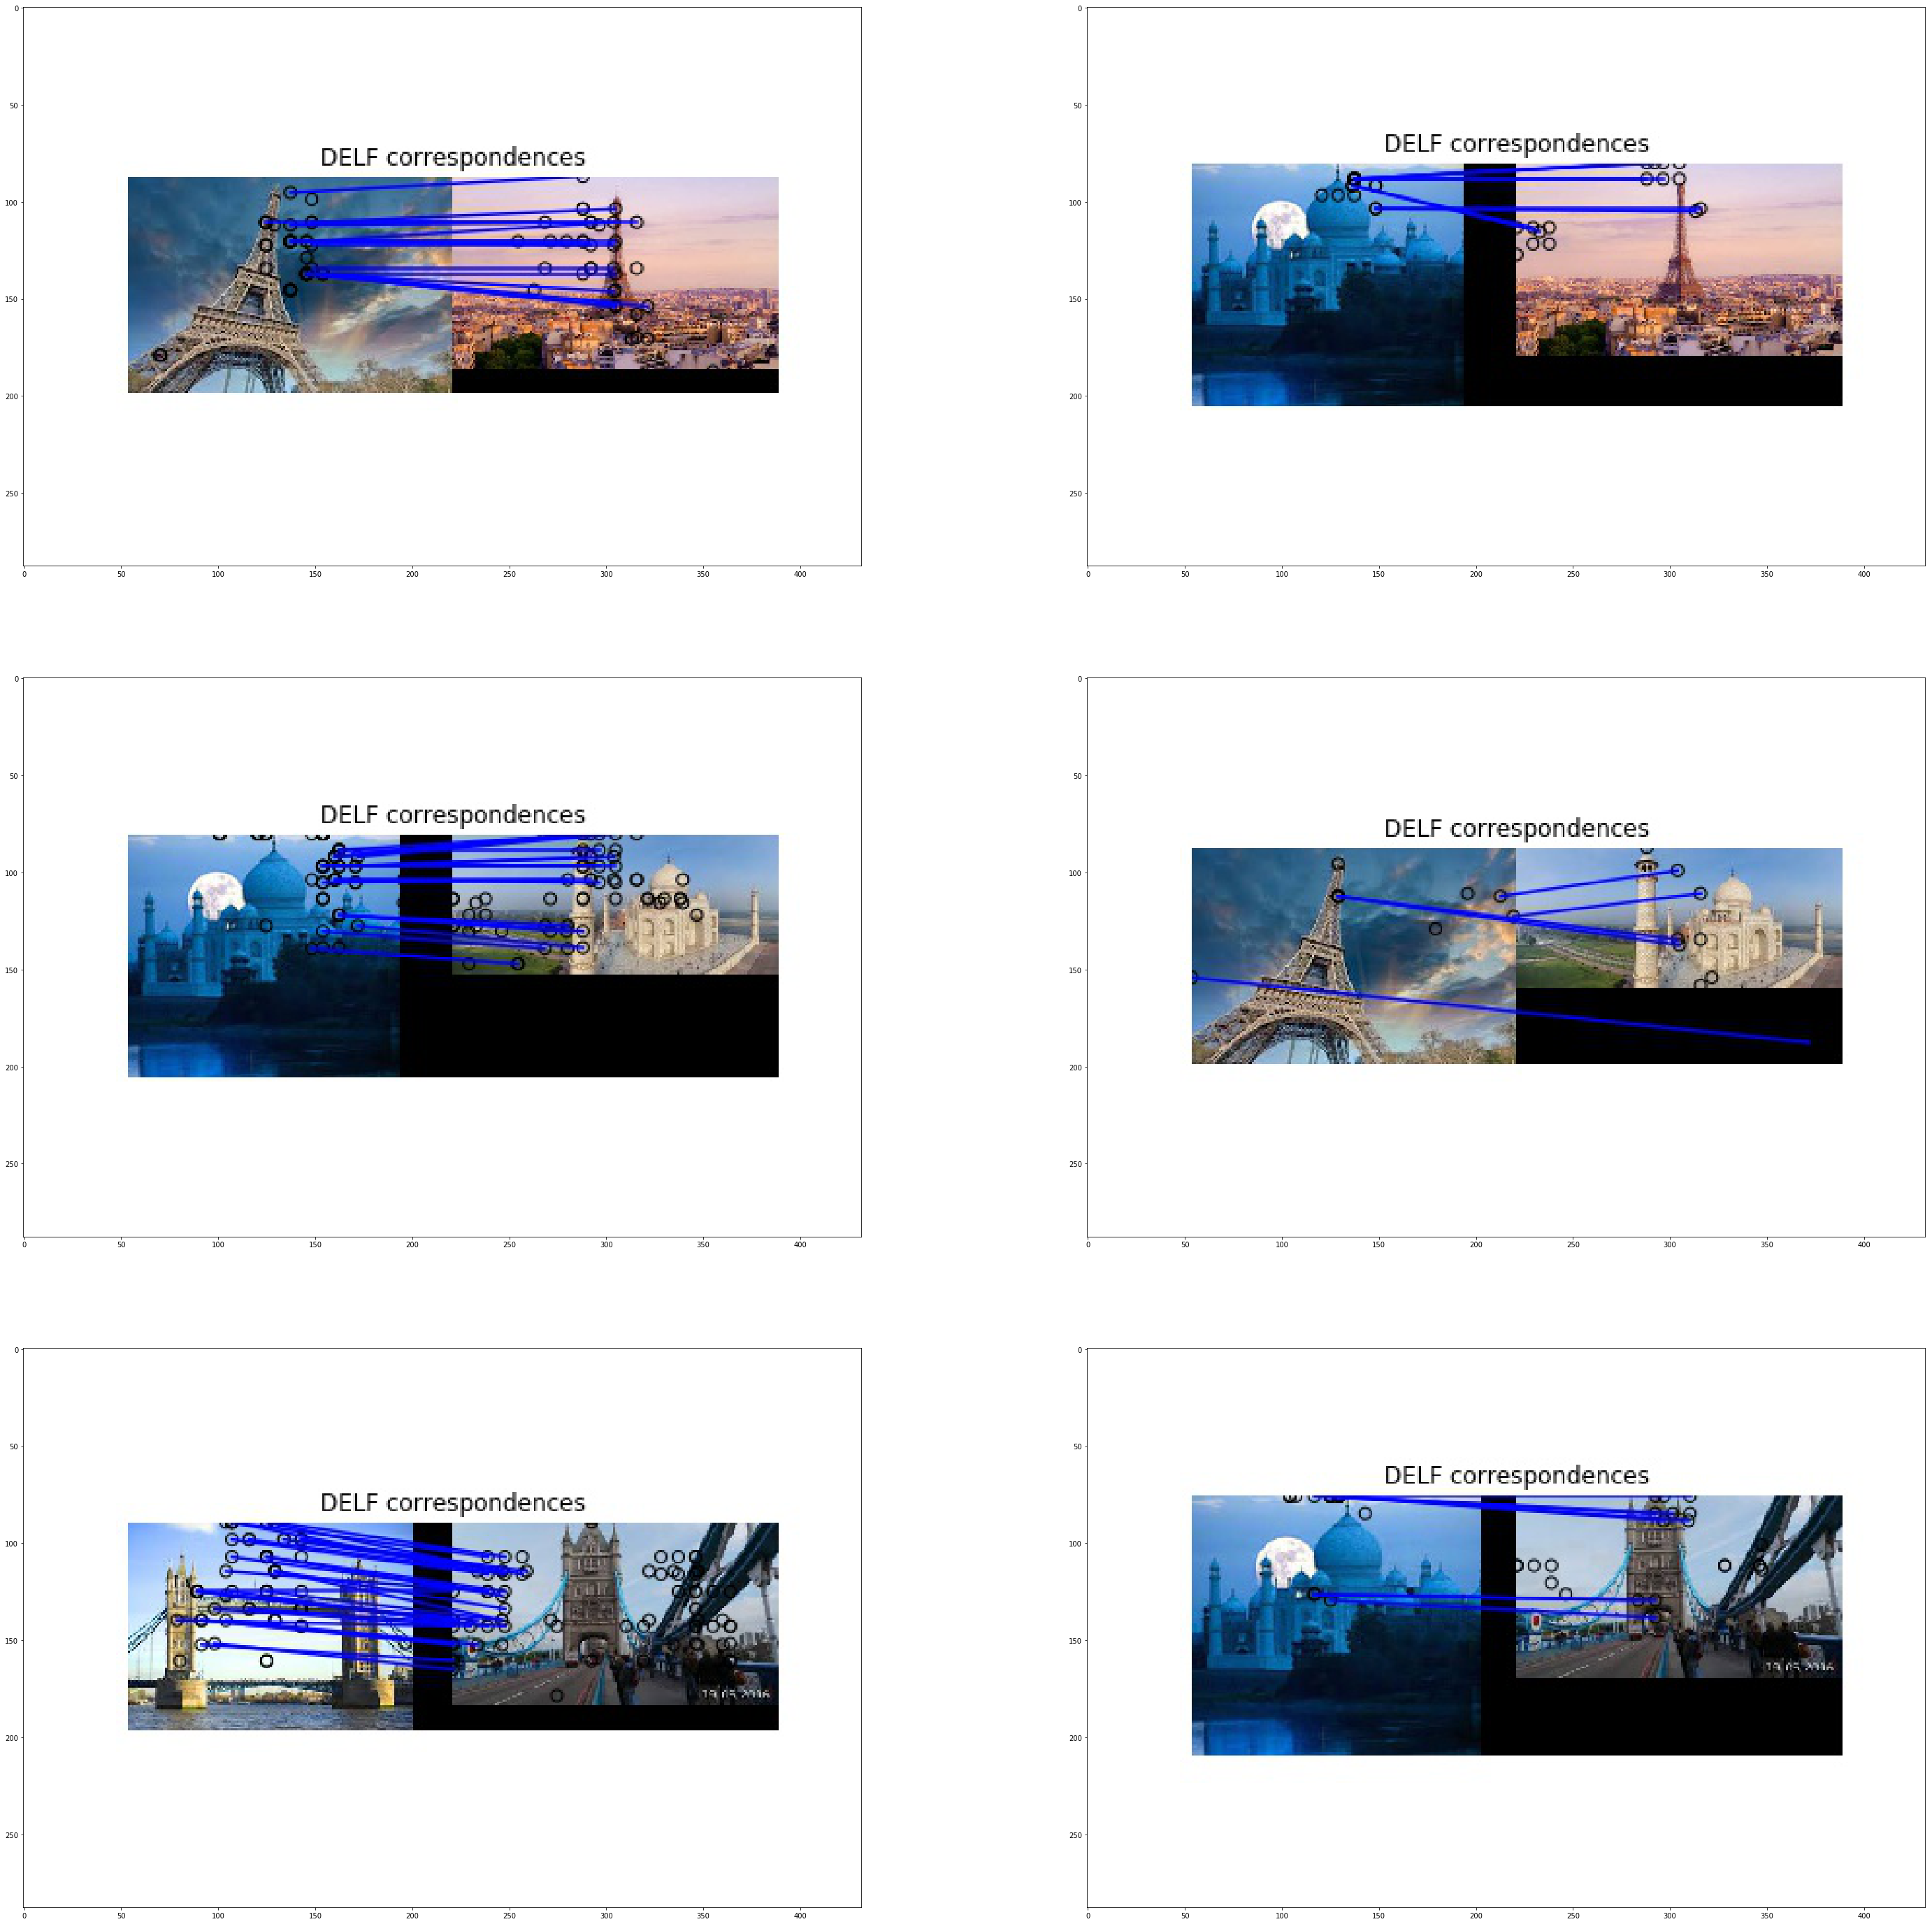

In [13]:
demo_lst = ['e->e1.jpg', 'e->t1.jpg', 't->t1.jpg', 't->e1.jpg','l->l2.jpg', 'l->t1.jpg']
EXAMPLE_NUM = 1
SAMPLE_NUM = 3

w=10
h=10

fig=plt.figure(figsize=(50, 50))
columns = EXAMPLE_NUM+1
rows = SAMPLE_NUM
for i in range(1, columns*rows +1):
    img = Image.open(demo_lst[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()